<a href="https://colab.research.google.com/github/diro5t/deep_quadric_learning/blob/main/TinyLinMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(C) Dirk Roeckmann 2023

Simple tinygrad MNIST ~100K parameter classifier with linear layers 784-128-10 and batch size of 64 modeled after the tinygrad quickstart.md

NOTE: The goal is NOT to find the minimum model or a certain target accuracy, but to compare it with a ~25K quadric model after the same number of epochs (see TinyQuadMNIST.ipynb).

More about quadric models here:

https://github.com/diro5t/deep_quadric_learning

This paradigm is based on my research here:

https://scholar.google.com/citations?hl=en&user=hamuGh4AAAAJ

### Install fresh tinygrad

In [ ]:
%cd /content

/content


In [ ]:
import shutil
def handler(func, path, exc_info):
    print(exc_info)
shutil.rmtree('tinygrad', onerror=handler)

In [ ]:
!git clone https://github.com/geohot/tinygrad.git

Cloning into 'tinygrad'...
remote: Enumerating objects: 14767, done.
remote: Counting objects: 100% (4251/4251), done.
remote: Compressing objects: 100% (445/445), done.
remote: Total 14767 (delta 3922), reused 3839 (delta 3802), pack-reused 10516
Receiving objects: 100% (14767/14767), 18.44 MiB | 23.17 MiB/s, done.
Resolving deltas: 100% (10534/10534), done.


In [ ]:
%cd tinygrad

/content/tinygrad


In [ ]:
!python3 -m pip install -e .

Obtaining file:///content/tinygrad
  Preparing metadata (setup.py) ... done
  Running setup.py develop for tinygrad


In [ ]:
!pip show tinygrad

Name: tinygrad
Version: 0.6.0
Summary: You like pytorch? You like micrograd? You love tinygrad! <3
Home-page: 
Author: George Hotz
Author-email: 
License: MIT
Location: /content/tinygrad
Editable project location: /content/tinygrad
Requires: networkx, numpy, pillow, pyopencl, PyYAML, requests, tqdm
Required-by: 


### Train and test the model

In [ ]:
# fetch mnist data
import numpy as np
import matplotlib.pyplot as plt

from extra.datasets import fetch_mnist
X_train, Y_train, X_test, Y_test = fetch_mnist()
X_train, X_test = X_train/255, X_test/255

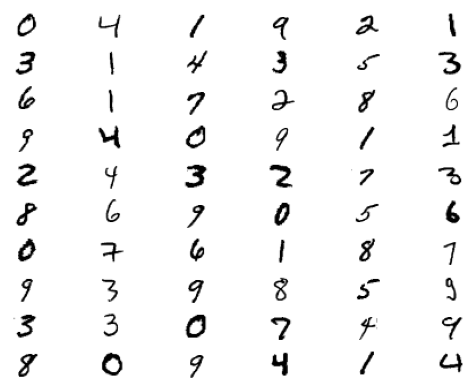

In [ ]:
# samples
figure = plt.figure()
for i in range(1, 61):
    plt.subplot(10, 6, i)
    plt.axis('off')
    plt.imshow(np.reshape(X_train[i], (28, 28)), cmap='gray_r')

In [ ]:
# linear model
from tinygrad.tensor import Tensor
from tinygrad.nn import Linear
from tinygrad.state import get_parameters

class TinyLinMnist:
  def __init__(self):
    self.l1 = Linear(784, 128, bias=False)
    self.l2 = Linear(128, 10, bias=False)

  def parameters(self):
    return get_parameters(self)

  def __call__(self, x):
    x = self.l1(x)
    x = x.leakyrelu()
    x = self.l2(x)
    return x.log_softmax()

model = TinyLinMnist()
model.parameters()

[<Tensor <LB (128, 784) dtypes.float op=BinaryOps.ADD st=ShapeTracker(shape=(128, 784), views=[View(shape=(128, 784), strides=(784, 1), offset=0, mask=None, contiguous=True, shape_strides=((100352, 1),))])> on CPU with grad None>,
 <Tensor <LB (10, 128) dtypes.float op=BinaryOps.ADD st=ShapeTracker(shape=(10, 128), views=[View(shape=(10, 128), strides=(128, 1), offset=0, mask=None, contiguous=True, shape_strides=((1280, 1),))])> on CPU with grad None>]

In [ ]:
# training
Tensor.training = True
from extra.training import sparse_categorical_crossentropy
from tinygrad.nn.optim import SGD
opt = SGD([model.l1.weight, model.l2.weight], lr=0.003)
steps = 2000
for step in range(steps):
  # random sample a batch
  samp = np.random.randint(0, X_train.shape[0], size=(64))
  batch = Tensor(X_train[samp], requires_grad=False)
  # get the corresponding labels
  labels = Y_train[samp]
  # forward pass
  out = model(batch)
  # compute loss
  loss = sparse_categorical_crossentropy(out, labels)
  # zero gradients
  opt.zero_grad()
  # backward pass
  loss.backward()
  # update parameters
  opt.step()
  # calculate accuracy
  pred = np.argmax(out.numpy(), axis=-1)
  acc = (pred == labels).mean()
  if step % 100 == 0:
    print(f"Step {step+1} | Loss: {loss.numpy()} | Accuracy: {acc}")

Step 1 | Loss: 0.412818044424057 | Accuracy: 0.890625
Step 101 | Loss: 0.7298752069473267 | Accuracy: 0.78125
Step 201 | Loss: 0.35981759428977966 | Accuracy: 0.890625
Step 301 | Loss: 0.5592283606529236 | Accuracy: 0.859375
Step 401 | Loss: 0.5854056477546692 | Accuracy: 0.875
Step 501 | Loss: 0.3270707130432129 | Accuracy: 0.890625
Step 601 | Loss: 0.36423200368881226 | Accuracy: 0.9375
Step 701 | Loss: 0.41924038529396057 | Accuracy: 0.890625
Step 801 | Loss: 0.36126789450645447 | Accuracy: 0.921875
Step 901 | Loss: 0.2548820674419403 | Accuracy: 0.9375
Step 1001 | Loss: 0.22326533496379852 | Accuracy: 0.984375
Step 1101 | Loss: 0.2876150608062744 | Accuracy: 0.90625
Step 1201 | Loss: 0.3491915762424469 | Accuracy: 0.890625
Step 1301 | Loss: 0.44293737411499023 | Accuracy: 0.875
Step 1401 | Loss: 0.43789204955101013 | Accuracy: 0.890625
Step 1501 | Loss: 0.2676992118358612 | Accuracy: 0.953125
Step 1601 | Loss: 0.3047407269477844 | Accuracy: 0.953125
Step 1701 | Loss: 0.262560218572

In [ ]:
# evaluation
import time
Tensor.training = False
st = time.perf_counter()
avg_acc = 0
for step in range(steps):
  # random sample a batch
  samp = np.random.randint(0, X_test.shape[0], size=(64))
  batch = Tensor(X_test[samp], requires_grad=False)
  # get the corresponding labels
  labels = Y_test[samp]
  # forward pass
  out = model(batch)
  # calculate accuracy
  pred = np.argmax(out.numpy(), axis=-1)
  avg_acc += (pred == labels).mean()
print(f"Test Accuracy: {avg_acc/steps}")
print(f"Time: {time.perf_counter() - st}")

Test Accuracy: 0.89709375
Time: 11.318332430000737
